加载MNIST数据集

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 定义数据预处理操作
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])
batch_size=128
# 加载训练集和测试集
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

定义深度自编码网络

In [6]:
# 定义深度自编码器网络
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # bottleneck 层的维度为2
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

模型的训练

In [22]:
import time

# 实例化深度自编码器模型
model = Autoencoder()

device='cuda'
model.to(device)
# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二元交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 参数设置
num_epochs = 10

# 训练过程中的损失函数列表
losses = []
# 每个epoch训练时间列表
epoch_times = []

# 训练模型
for epoch in range(num_epochs):
    start_time = time.time()  # 记录每个epoch的开始时间
    for batch_idx, (data, _) in enumerate(train_loader):
        data=data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Epoch: {}, Batch: {}, Loss: {:.6f}'.format(epoch+1, batch_idx, loss.item()))

    # 在测试集上进行重构并计算重构误差
    total_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data=data.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            loss = criterion(output, data)
            total_loss += loss.item()

        average_loss = total_loss / len(test_loader)
        losses.append(average_loss)
        print('Average Reconstruction Loss: {:.6f}'.format(average_loss))
    end_time = time.time()  # 记录每个epoch的结束时间
    # 计算每个epoch训练所花时间
    epoch_time = end_time - start_time 
    epoch_times.append(epoch_time)
    print('Epoch: {}, Time: {:.2f} seconds'.format(epoch+1, epoch_time))



Epoch: 1, Batch: 0, Loss: 0.692332
Epoch: 1, Batch: 100, Loss: 0.250361
Epoch: 1, Batch: 200, Loss: 0.220852
Epoch: 1, Batch: 300, Loss: 0.230601
Epoch: 1, Batch: 400, Loss: 0.220036
Average Reconstruction Loss: 0.220443
Epoch: 1, Time: 8.50 seconds
Epoch: 2, Batch: 0, Loss: 0.223243
Epoch: 2, Batch: 100, Loss: 0.207056
Epoch: 2, Batch: 200, Loss: 0.218278
Epoch: 2, Batch: 300, Loss: 0.219047
Epoch: 2, Batch: 400, Loss: 0.204415
Average Reconstruction Loss: 0.204465
Epoch: 2, Time: 8.54 seconds
Epoch: 3, Batch: 0, Loss: 0.208299
Epoch: 3, Batch: 100, Loss: 0.208045
Epoch: 3, Batch: 200, Loss: 0.197117
Epoch: 3, Batch: 300, Loss: 0.195766
Epoch: 3, Batch: 400, Loss: 0.197862
Average Reconstruction Loss: 0.196136
Epoch: 3, Time: 8.38 seconds
Epoch: 4, Batch: 0, Loss: 0.193614
Epoch: 4, Batch: 100, Loss: 0.194744
Epoch: 4, Batch: 200, Loss: 0.197233
Epoch: 4, Batch: 300, Loss: 0.187338
Epoch: 4, Batch: 400, Loss: 0.193438
Average Reconstruction Loss: 0.191763
Epoch: 4, Time: 8.46 seconds


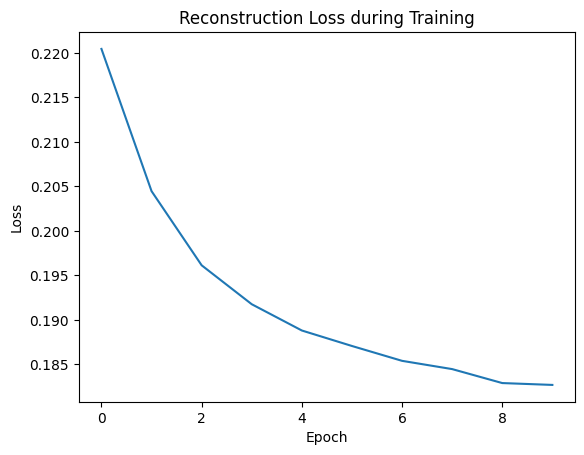

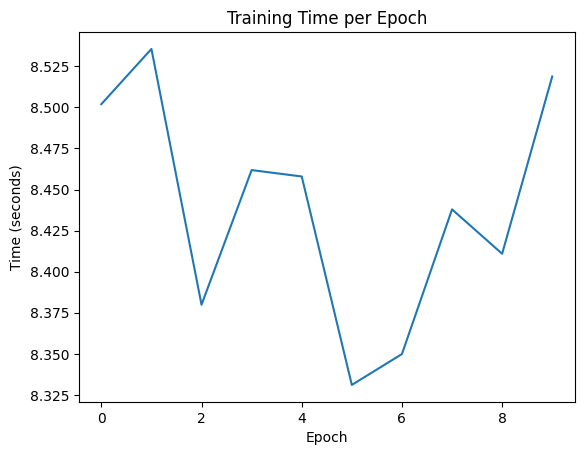

In [23]:
import matplotlib.pyplot as plt
# 绘制损失函数变化图表
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reconstruction Loss during Training')
plt.show()

# 绘制每个epoch训练时间变化图表
plt.plot(epoch_times)
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.show()

In [ ]:
# 保存模型
torch.save(model, './model/autoencoder.pth')
torch.save(model.state_dict(), './model/autoencoder_dict.pth')

添加高斯白噪声

In [24]:
import numpy as np
import os


class add_noise(nn.Module):
    def __init__(self, std,factor):
        super(add_noise, self).__init__()
        self.std = std  # 标准差
        self.factor=factor#加入噪声因子


    # 生成高斯噪声
    def gaussian_noise_layer(self, input_layer, std,factor):
        noise = torch.normal(mean=0.0, std=std, size=np.shape(input_layer))
        # if self.config.CUDA:
        noise = noise.to(input_layer.get_device())
        noise_data=input_layer + factor*noise
        return noise_data
    # 进行归一化
    def normalize(self, x):
        pwr = torch.mean(x ** 2) * 2
        out = x / torch.sqrt(pwr)
        return out

    def forward(self, input):
        latent_code = self.normalize(input)
        noisy_code = self.gaussian_noise_layer(latent_code, self.std,self.factor)
        return noisy_code

在对模型的验证中加入高斯白噪声


In [25]:
import time

# 实例化深度自编码器模型
model = Autoencoder()

device='cuda'
model.to(device)
# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二元交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)

#添加噪声
std=1
factor=0.4
noise_layer=add_noise(std,factor)

# 参数设置
num_epochs = 50


# 训练过程中的损失函数列表
losses = []
# 每个epoch训练时间列表
epoch_times = []

# 训练模型
for epoch in range(num_epochs):
    start_time = time.time()  # 记录每个epoch的开始时间
    for batch_idx, (data,_) in enumerate(train_loader):
        data=data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        
        # 添加噪声
        noise_data = noise_layer(data)
        
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
      
        if batch_idx % 100 == 0:
            print('Epoch: {}, Batch: {}, Loss: {:.6f}'.format(epoch+1, batch_idx, loss.item()))
    end_time = time.time()  # 记录每个epoch的结束时间
    # 计算每个epoch训练所花时间
    epoch_time = end_time - start_time 
    epoch_times.append(epoch_time)
    print('Epoch: {}, Time: {:.2f} seconds'.format(epoch+1, epoch_time))
print('Finish')


# 在测试集上进行重构并计算重构误差
model.eval()
total_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data=data.to(device)
        data = data.view(data.size(0), -1)

        # 添加噪声
        noise_data = noise_layer(data)

        output = model(data)
        
        loss = criterion(output, data)
        total_loss += loss.item()

    average_loss = total_loss / len(test_loader)
    losses.append(average_loss)
    print('Average Reconstruction Loss: {:.6f}'.format(average_loss))



Epoch: 1, Batch: 0, Loss: 0.693005
Epoch: 1, Batch: 100, Loss: 0.263840
Epoch: 1, Batch: 200, Loss: 0.249557
Epoch: 1, Batch: 300, Loss: 0.228177
Epoch: 1, Batch: 400, Loss: 0.228025
Epoch: 1, Time: 7.71 seconds
Epoch: 2, Batch: 0, Loss: 0.223099
Epoch: 2, Batch: 100, Loss: 0.204950
Epoch: 2, Batch: 200, Loss: 0.218288
Epoch: 2, Batch: 300, Loss: 0.220182
Epoch: 2, Batch: 400, Loss: 0.202676
Epoch: 2, Time: 7.73 seconds
Epoch: 3, Batch: 0, Loss: 0.211547
Epoch: 3, Batch: 100, Loss: 0.192726
Epoch: 3, Batch: 200, Loss: 0.202712
Epoch: 3, Batch: 300, Loss: 0.201952
Epoch: 3, Batch: 400, Loss: 0.192348
Epoch: 3, Time: 7.64 seconds
Epoch: 4, Batch: 0, Loss: 0.192527
Epoch: 4, Batch: 100, Loss: 0.188648
Epoch: 4, Batch: 200, Loss: 0.186862
Epoch: 4, Batch: 300, Loss: 0.192139
Epoch: 4, Batch: 400, Loss: 0.199082
Epoch: 4, Time: 7.61 seconds
Epoch: 5, Batch: 0, Loss: 0.181712
Epoch: 5, Batch: 100, Loss: 0.193779
Epoch: 5, Batch: 200, Loss: 0.198758
Epoch: 5, Batch: 300, Loss: 0.178010
Epoch:

In [ ]:
# 保存模型
torch.save(model, './model/autoencoder_noise.pth')
torch.save(model.state_dict(), './model/autoencoder_dict_noise.pth')

 在测试集上展示降噪成果

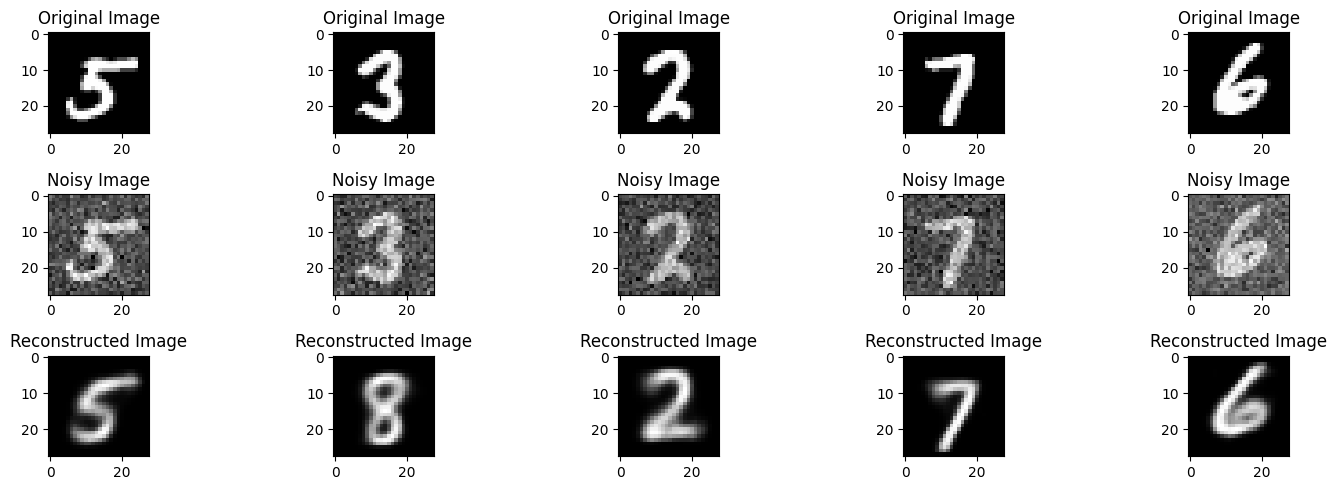

In [33]:
import random
import matplotlib.pyplot as plt

# 随机选择五个样本进行可视化
sample_indices = random.sample(range(len(data)), 5) # 随机选择5个索引

sample_data = data[sample_indices].cpu() # 获取随机选择的样本，并将其移回CPU上
plt.figure(figsize=(15, 5))
for i in range(5):
    # 原始图像
    plt.subplot(3, 5, i + 1)
    plt.imshow(sample_data[i].view(28, 28), cmap='gray')
    plt.title('Original Image')

# 添加噪声后的图像
noisy_sample_data = noise_data[sample_indices].cpu()
for i in range(5):
    plt.subplot(3, 5, 5 + i + 1)
    plt.imshow(noisy_sample_data[i].view(28, 28), cmap='gray')
    plt.title('Noisy Image')

# 重构图像
reconstructed_sample = output[sample_indices].cpu()
for i in range(5):    
    plt.subplot(3, 5, 10 + i + 1)
    plt.imshow(reconstructed_sample[i].view(28, 28), cmap='gray')
    plt.title('Reconstructed Image')

plt.tight_layout()
plt.show()


问题4

训练代码保持不变

In [4]:

# 实例化深度自编码器模型
model = Autoencoder()

device='cuda'
model.to(device)
# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二元交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
import time


# 参数设置
num_epochs = 100

# 训练过程中的损失函数列表
losses = []
# 每个epoch训练时间列表
epoch_times = []

# 训练模型
for epoch in range(num_epochs):
    start_time = time.time()  # 记录每个epoch的开始时间
    for batch_idx, (data, labels) in enumerate(train_loader):
        data=data.to(device)
        data = data.view(data.size(0), -1)


        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Epoch: {}, Batch: {}, Loss: {:.6f}'.format(epoch+1, batch_idx, loss.item()))
    end_time = time.time()  # 记录每个epoch的结束时间
    # 计算每个epoch训练所花时间
    epoch_time = end_time - start_time 
    epoch_times.append(epoch_time)
    print('Epoch: {}, Time: {:.2f} seconds'.format(epoch+1, epoch_time))

Epoch: 1, Batch: 0, Loss: 0.695000
Epoch: 1, Batch: 100, Loss: 0.257691
Epoch: 1, Batch: 200, Loss: 0.242453
Epoch: 1, Batch: 300, Loss: 0.242224
Epoch: 1, Batch: 400, Loss: 0.223535
Epoch: 1, Time: 7.81 seconds
Epoch: 2, Batch: 0, Loss: 0.221455
Epoch: 2, Batch: 100, Loss: 0.224260
Epoch: 2, Batch: 200, Loss: 0.225677
Epoch: 2, Batch: 300, Loss: 0.204449
Epoch: 2, Batch: 400, Loss: 0.206823
Epoch: 2, Time: 7.56 seconds
Epoch: 3, Batch: 0, Loss: 0.198893
Epoch: 3, Batch: 100, Loss: 0.197778
Epoch: 3, Batch: 200, Loss: 0.209973
Epoch: 3, Batch: 300, Loss: 0.210391
Epoch: 3, Batch: 400, Loss: 0.193851
Epoch: 3, Time: 7.47 seconds
Epoch: 4, Batch: 0, Loss: 0.203277
Epoch: 4, Batch: 100, Loss: 0.196993
Epoch: 4, Batch: 200, Loss: 0.210882
Epoch: 4, Batch: 300, Loss: 0.192564
Epoch: 4, Batch: 400, Loss: 0.202576
Epoch: 4, Time: 7.64 seconds
Epoch: 5, Batch: 0, Loss: 0.197133
Epoch: 5, Batch: 100, Loss: 0.198138
Epoch: 5, Batch: 200, Loss: 0.187997
Epoch: 5, Batch: 300, Loss: 0.187296
Epoch:

In [6]:
# 保存模型
torch.save(model, './model/autoencoder_4.pth')
torch.save(model.state_dict(), './model/autoencoder_dict_4.pth')

In [34]:
model=torch.load("./model/autoencoder_4.pth").to('cuda')

In [35]:
latent_codes=[]
latent_labels=[]
with torch.no_grad():
    for data,labels in test_loader:
        data=data.to('cuda')
        latent_code=model.encoder(data.view(-1,784))
        latent_codes.append(latent_code)  # 将潜在表示转换为numpy数组
        latent_labels.append(labels)  # 将labels转换为numpy数组


In [36]:
#将列表转变为张量
latent_codes=torch.cat(latent_codes,dim=0)
latent_labels=torch.cat(latent_labels,dim=0)

In [37]:
print(latent_codes.shape)

torch.Size([10000, 2])


进行可视化展示

In [38]:
latent_codes=latent_codes.cpu().detach().numpy()

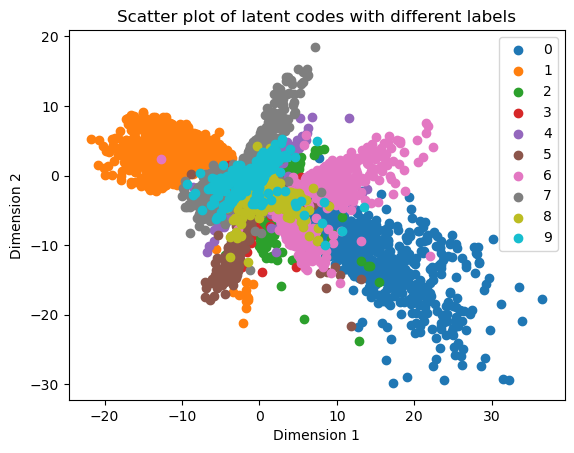

In [39]:
import matplotlib.pyplot as plt
for i in range(10):
    indices = (latent_labels == i).nonzero().squeeze()
    plt.scatter(latent_codes[indices, 0], latent_codes[indices, 1], label=str(i), alpha=1)
    plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot of latent codes with different labels')
plt.show()

#### 采样

根据上图的结果，选择采样的范围

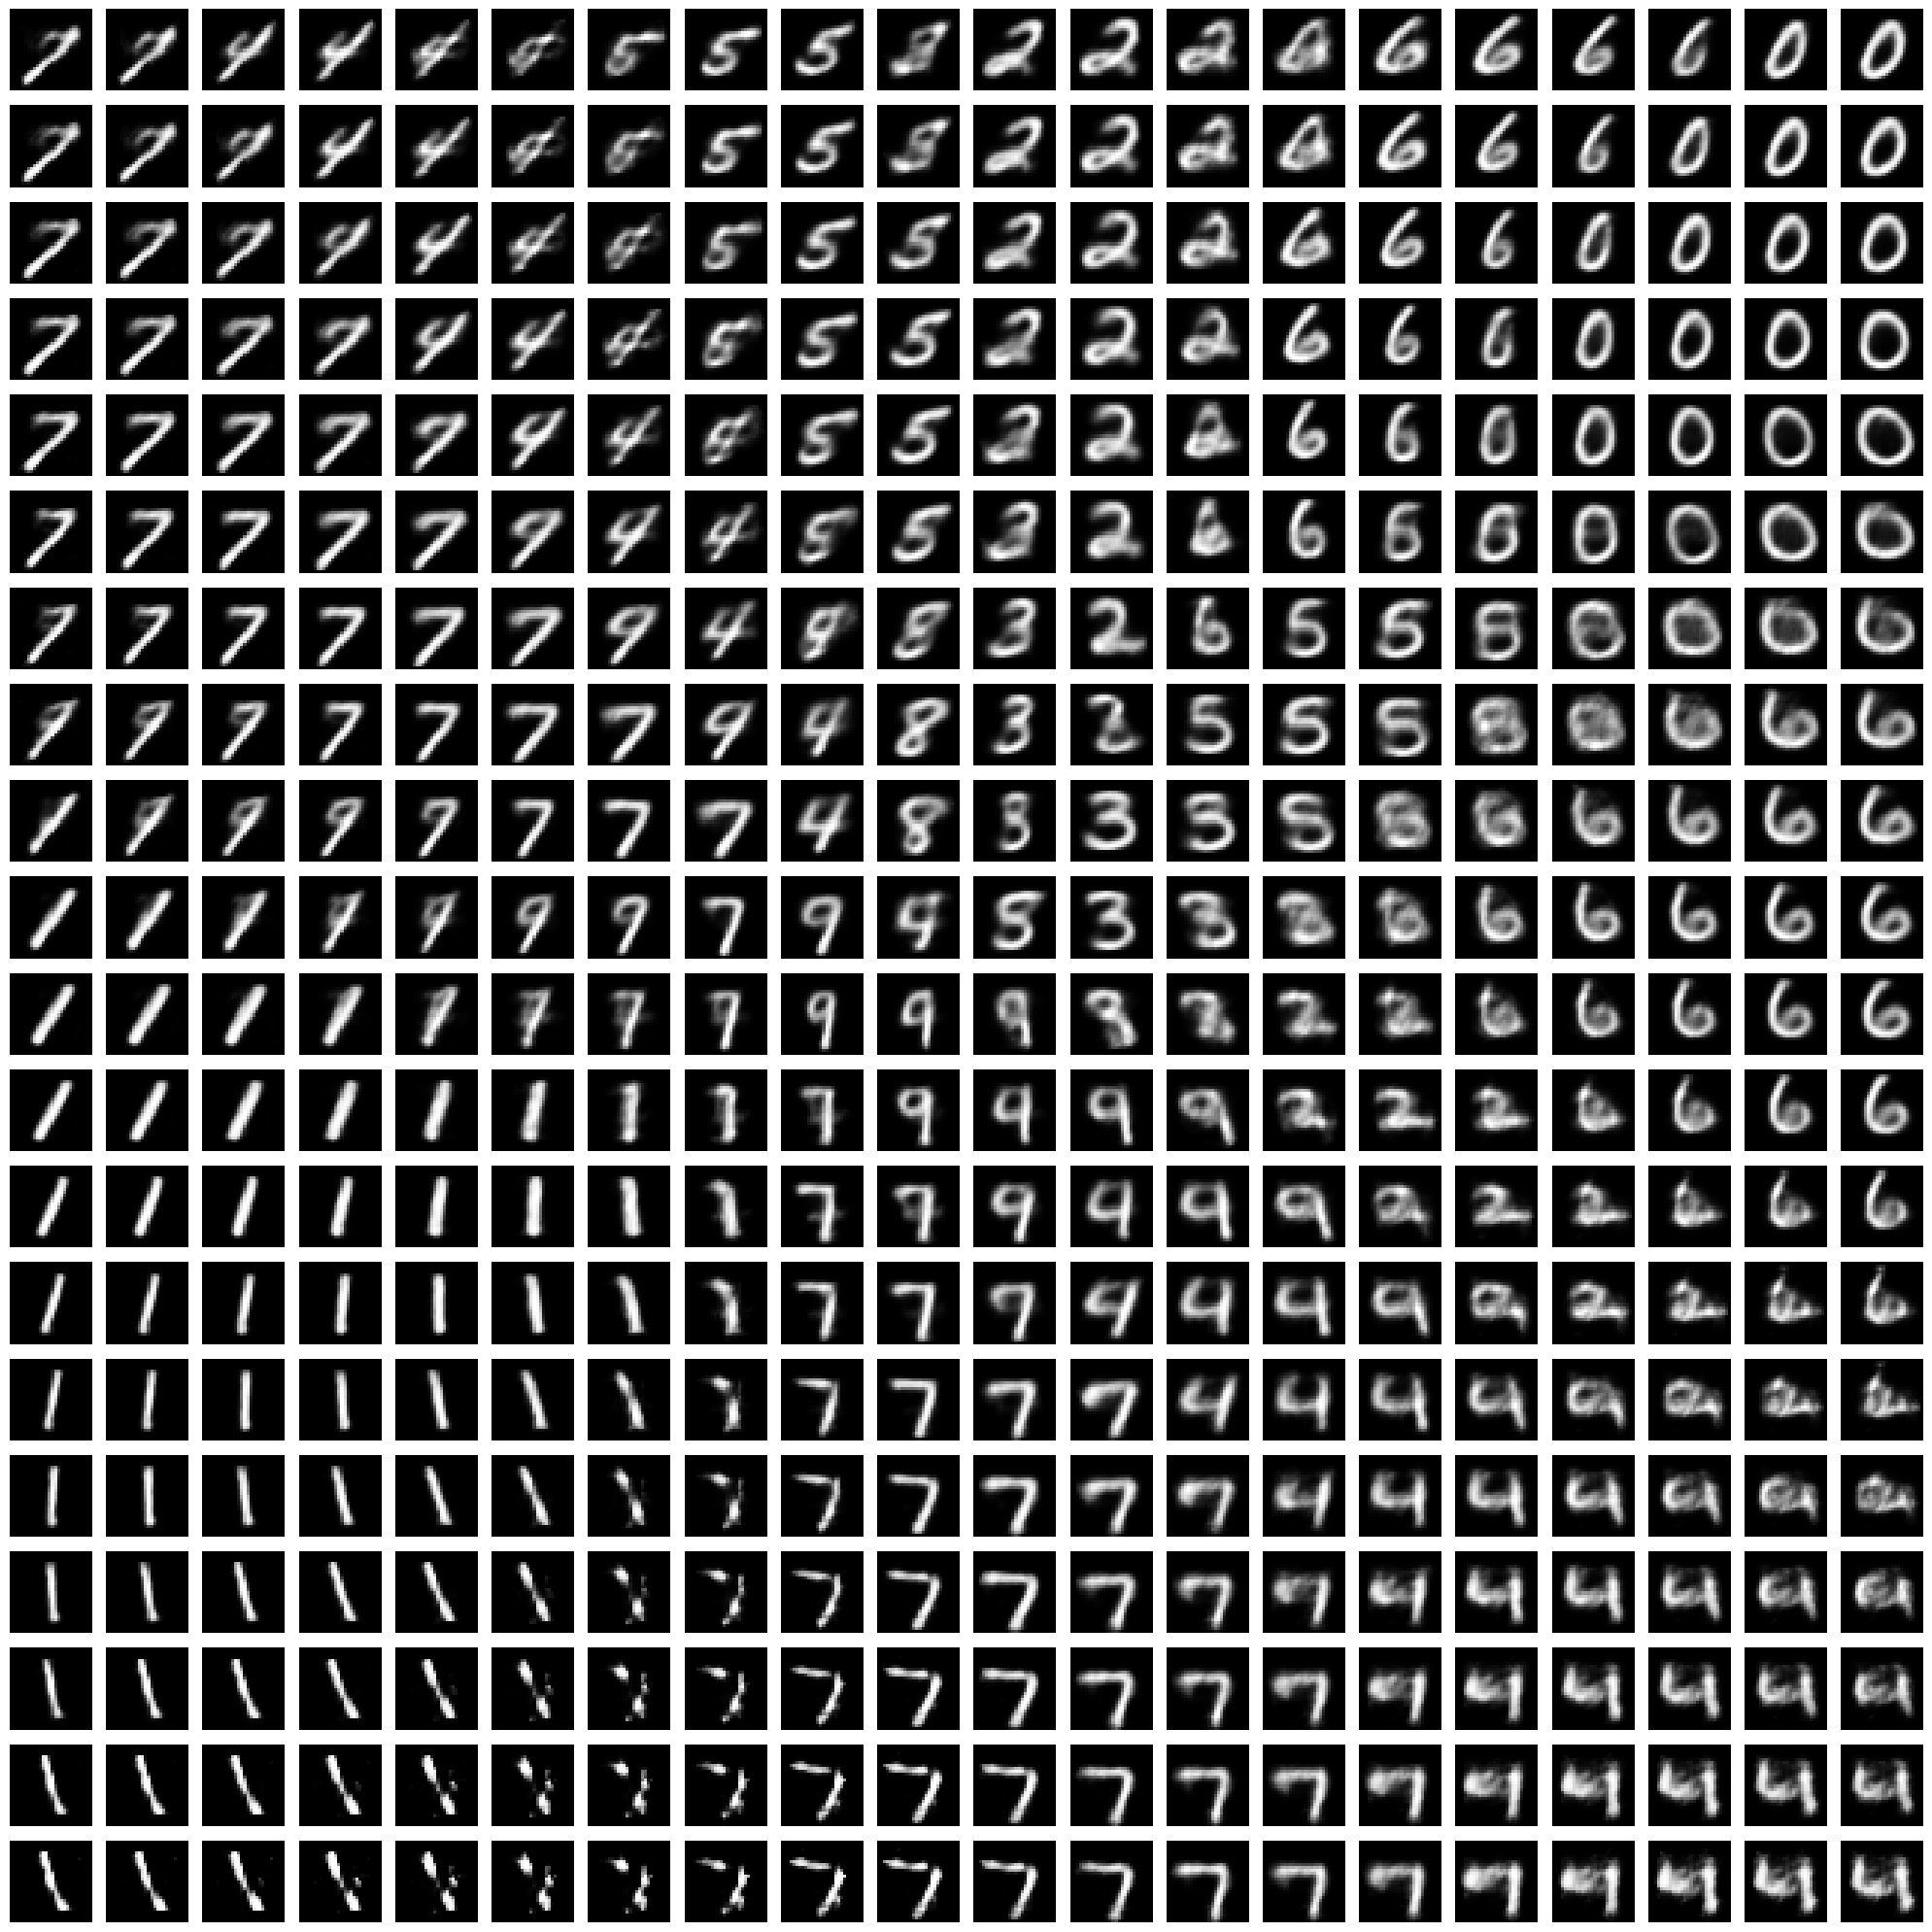

In [40]:
import numpy as np
# 设置 latent code 的维度和采样间隔
latent_dim = 2
sampling_interval = 1

# 构建采样点集合,在两个维度上进行采样
sampling_points = np.array([
    np.arange(-10, 10, sampling_interval),
    np.arange(-10, 10, sampling_interval)
])

# 生成所有可能的采样点组合
sampling_grid = np.meshgrid(*sampling_points)   #生成网格图
sampling_grid = np.stack(sampling_grid, axis=-1).reshape(-1, latent_dim)   #stack将网格图中的点写成numpy数组

# 将 numpy 数组转换为 PyTorch Tensor
sampling_grid_tensor = torch.tensor(sampling_grid, dtype=torch.float32)
sampling_grid_tensor = sampling_grid_tensor.to(device)

# 解码采样点
decoded_images = model.decoder(sampling_grid_tensor)
# 将 Tensor 转换为 numpy 数组以便后续处理或可视化
decoded_images_np = decoded_images.cpu().detach().numpy()


# 绘制图像重建结果
import matplotlib.pyplot as plt

n_samples = decoded_images_np.shape[0]
n_cols = 20  # 每行显示的图像数量
n_rows = n_samples // n_cols
image_shape = (28,28)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(decoded_images_np[i].reshape(image_shape), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

#### 任务5

In [22]:
import time

# 实例化深度自编码器模型
model = Autoencoder()

device='cuda'
model.to(device)

# 定义L2正则化的权重衰减系数
l2_weight_decay = 0.0001

# 定义损失函数，包括重构损失和L2正则化项
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_weight_decay)

In [23]:
import time

# 存储编码后的潜在表示
latent_codes = []
latent_labels = []

# 参数设置
num_epochs = 100

# 训练过程中的损失函数列表
losses = []
# 每个epoch训练时间列表
epoch_times = []

# 训练模型
for epoch in range(num_epochs):
    start_time = time.time()  # 记录每个epoch的开始时间
    for batch_idx, (data, labels) in enumerate(train_loader):
        data=data.to(device)
        data = data.view(data.size(0), -1)

        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Epoch: {}, Batch: {}, Loss: {:.6f}'.format(epoch+1, batch_idx, loss.item()))
    end_time = time.time()  # 记录每个epoch的结束时间
    # 计算每个epoch训练所花时间
    epoch_time = end_time - start_time 
    epoch_times.append(epoch_time)
    print('Epoch: {}, Time: {:.2f} seconds'.format(epoch+1, epoch_time))

Epoch: 1, Batch: 0, Loss: 0.231988
Epoch: 1, Batch: 100, Loss: 0.069389
Epoch: 1, Batch: 200, Loss: 0.059935
Epoch: 1, Batch: 300, Loss: 0.058596
Epoch: 1, Batch: 400, Loss: 0.055017
Epoch: 1, Time: 8.12 seconds
Epoch: 2, Batch: 0, Loss: 0.053952
Epoch: 2, Batch: 100, Loss: 0.054320
Epoch: 2, Batch: 200, Loss: 0.057762
Epoch: 2, Batch: 300, Loss: 0.053723
Epoch: 2, Batch: 400, Loss: 0.054507
Epoch: 2, Time: 8.19 seconds
Epoch: 3, Batch: 0, Loss: 0.051137
Epoch: 3, Batch: 100, Loss: 0.054008
Epoch: 3, Batch: 200, Loss: 0.053175
Epoch: 3, Batch: 300, Loss: 0.054331
Epoch: 3, Batch: 400, Loss: 0.054659
Epoch: 3, Time: 8.15 seconds
Epoch: 4, Batch: 0, Loss: 0.054981
Epoch: 4, Batch: 100, Loss: 0.055196
Epoch: 4, Batch: 200, Loss: 0.051871
Epoch: 4, Batch: 300, Loss: 0.053219
Epoch: 4, Batch: 400, Loss: 0.052981
Epoch: 4, Time: 8.41 seconds
Epoch: 5, Batch: 0, Loss: 0.050742
Epoch: 5, Batch: 100, Loss: 0.054675
Epoch: 5, Batch: 200, Loss: 0.053242
Epoch: 5, Batch: 300, Loss: 0.048984
Epoch:

In [24]:
# 保存模型
torch.save(model, './model/autoencoder_4l2.pth')
torch.save(model.state_dict(), './model/autoencoder_dict_4l2.pth')

In [41]:
model=torch.load("./model/autoencoder_4l2.pth").to('cuda')

In [42]:
latent_codes=[]
latent_labels=[]
with torch.no_grad():
    for data,labels in test_loader:
        data=data.to('cuda')
        latent_code=model.encoder(data.view(-1,784))
        latent_codes.append(latent_code)  # 将潜在表示转换为numpy数组
        latent_labels.append(labels)  # 将labels转换为numpy数组

In [43]:
#将列表转变为张量
latent_codes=torch.cat(latent_codes,dim=0)
latent_labels=torch.cat(latent_labels,dim=0)

In [44]:
latent_codes=latent_codes.cpu().detach().numpy()

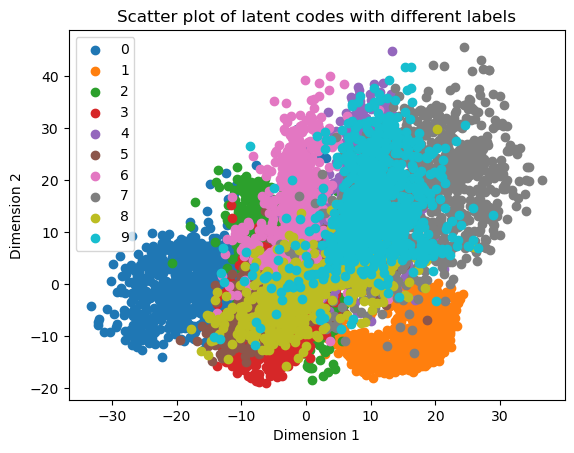

In [45]:
import matplotlib.pyplot as plt
for i in range(10):
    indices = (latent_labels == i).nonzero().squeeze()
    plt.scatter(latent_codes[indices, 0], latent_codes[indices, 1], label=str(i), alpha=1)
    plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot of latent codes with different labels')
plt.show()

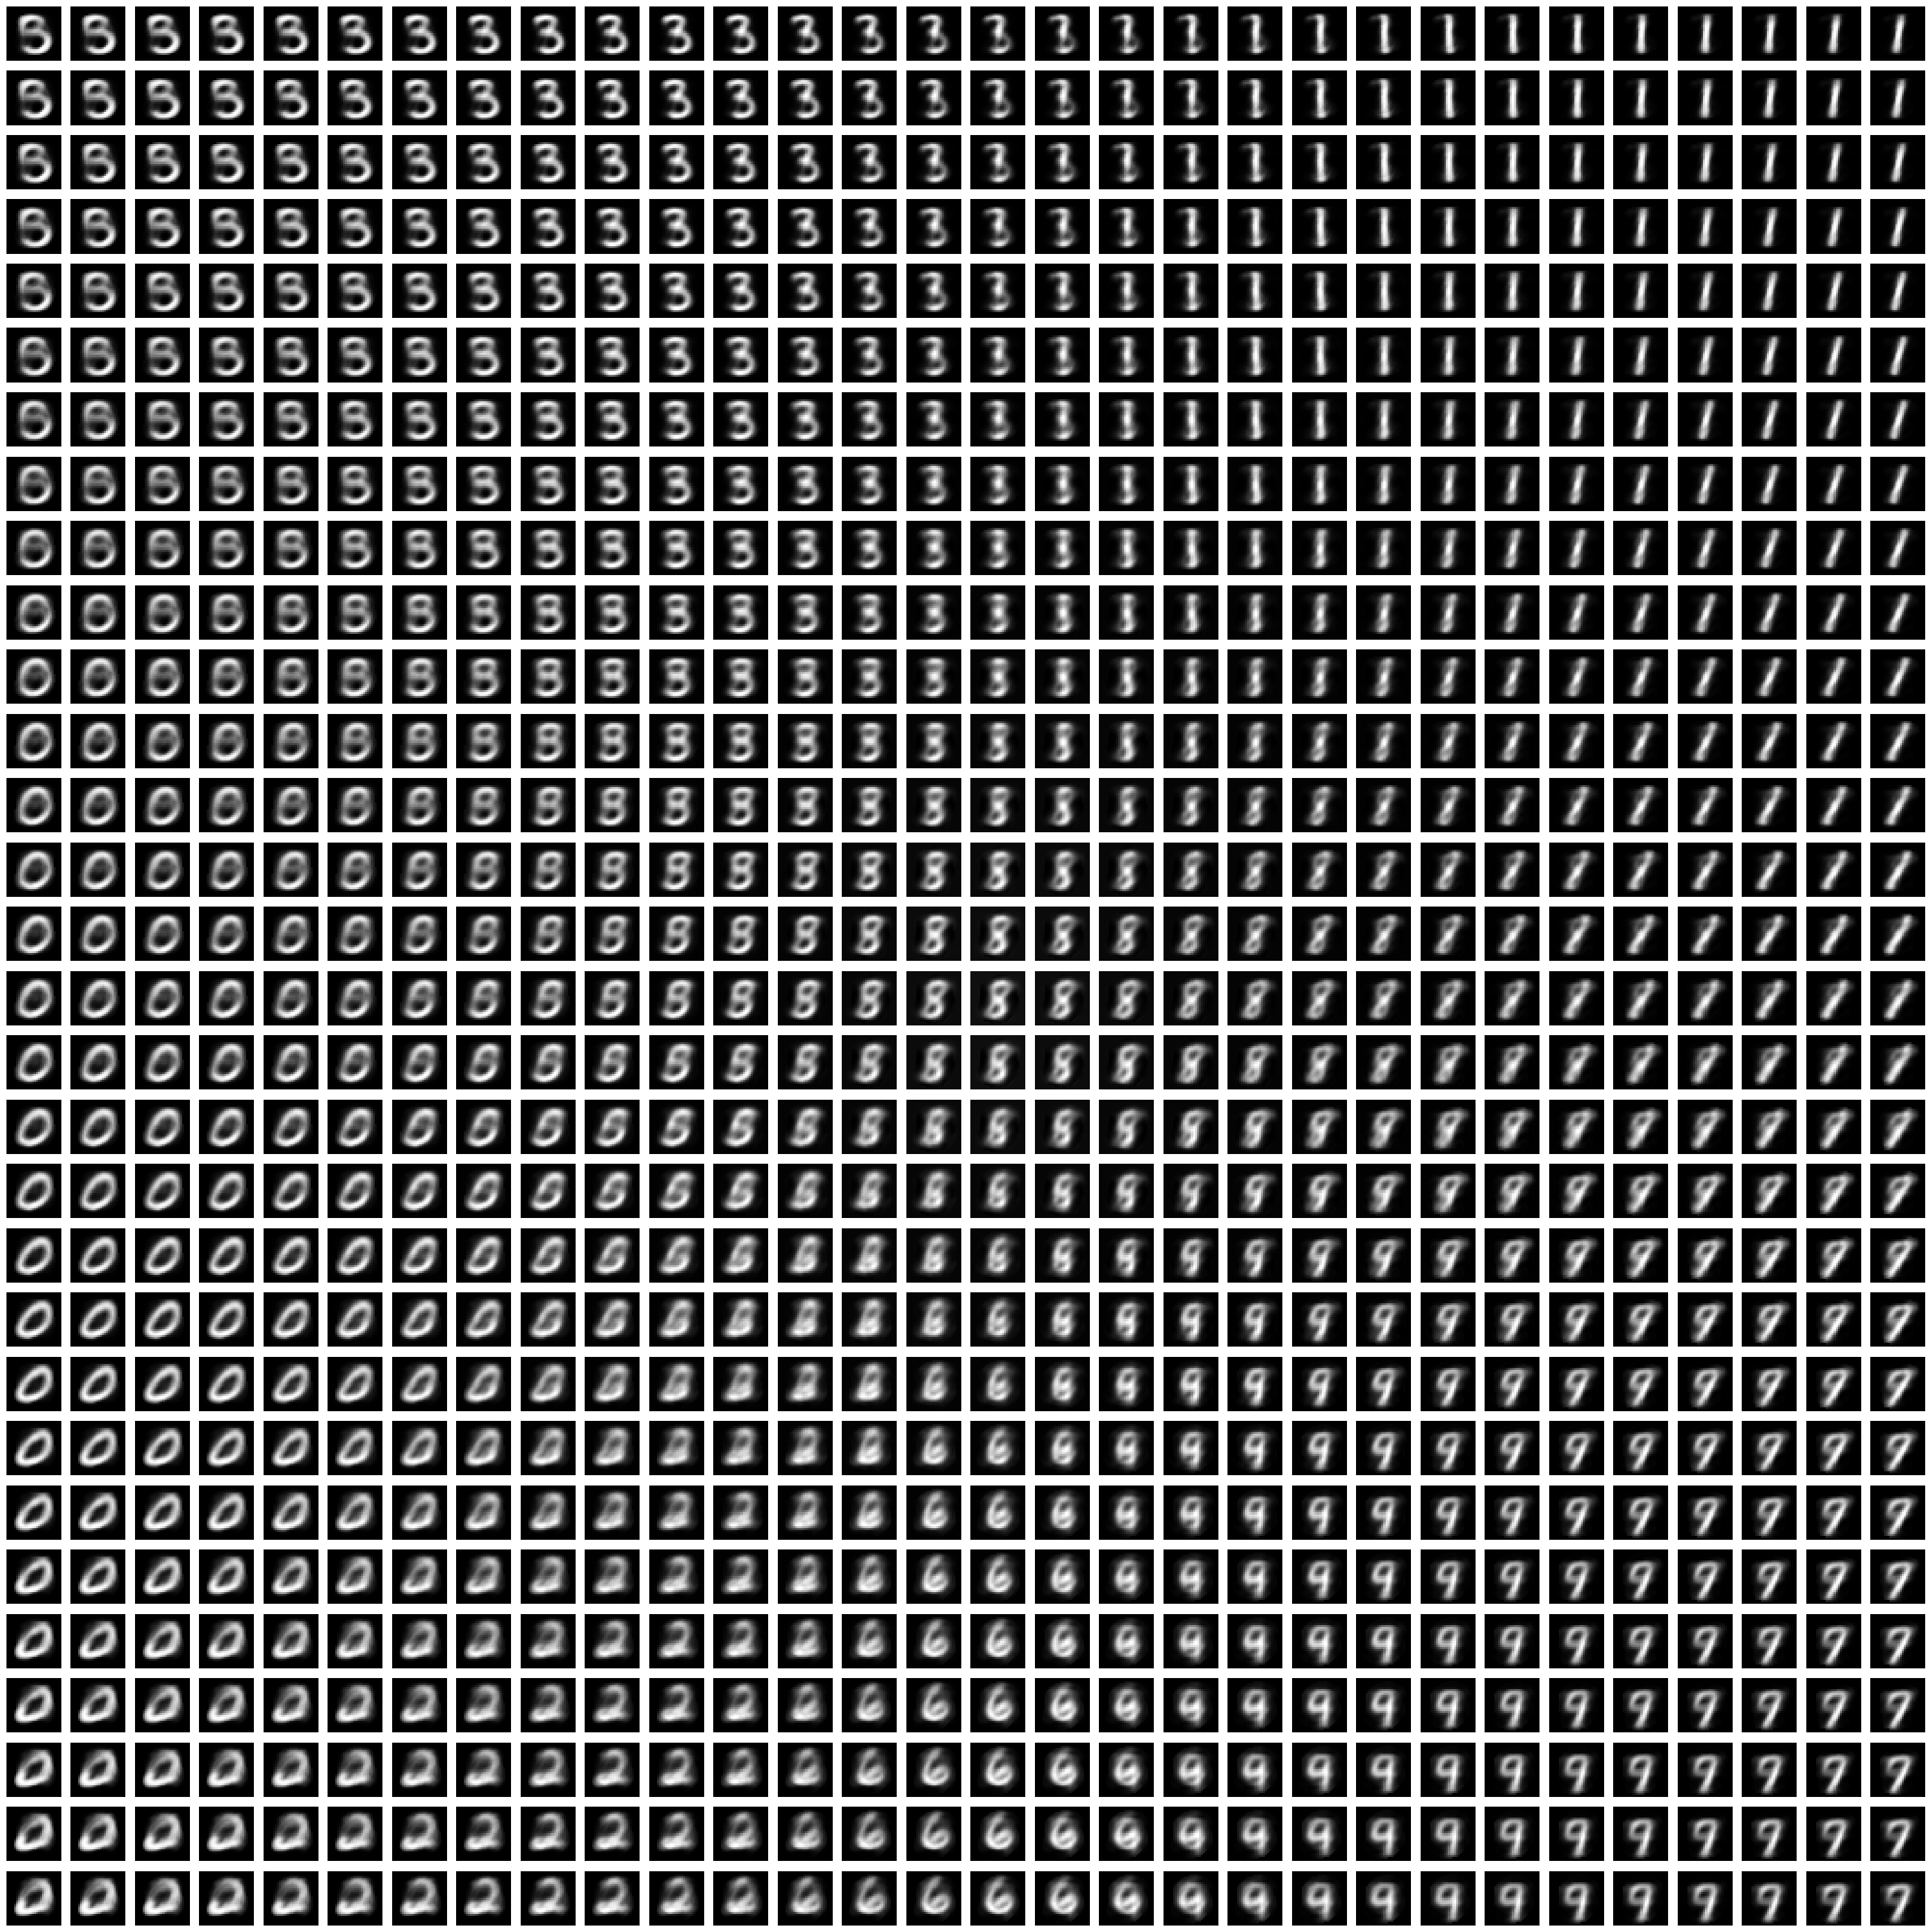

In [46]:
import numpy as np
# 设置 latent code 的维度和采样间隔
latent_dim = 2
sampling_interval = 1

# 构建采样点集合,在两个维度上进行采样
sampling_points = np.array([
    np.arange(-15, 15, sampling_interval),
    np.arange(-15, 15, sampling_interval)
])

# 生成所有可能的采样点组合
sampling_grid = np.meshgrid(*sampling_points)   #生成网格图
sampling_grid = np.stack(sampling_grid, axis=-1).reshape(-1, latent_dim)   #stack将网格图中的点写成numpy数组

# 将 numpy 数组转换为 PyTorch Tensor
sampling_grid_tensor = torch.tensor(sampling_grid, dtype=torch.float32)
sampling_grid_tensor = sampling_grid_tensor.to(device)

# 解码采样点
decoded_images = model.decoder(sampling_grid_tensor)
# 将 Tensor 转换为 numpy 数组以便后续处理或可视化
decoded_images_np = decoded_images.cpu().detach().numpy()


# 绘制图像重建结果
import matplotlib.pyplot as plt

n_samples = decoded_images_np.shape[0]
n_cols = 30  # 每行显示的图像数量
n_rows = n_samples // n_cols
image_shape = (28,28)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 30))
for i, ax in enumerate(axes.flat):
    ax.imshow(decoded_images_np[i].reshape(image_shape), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()